In [3]:
import os
import csv
import torchaudio
import pandas as pd
import numpy as np
import torch

FREQ = 16000

# Define the paths to the data files and folders
dataset_folder_path = './data/bach-violin-dataset-v1.0/'
audio_csv_path = os.path.join(dataset_folder_path, 'audio.csv')
info_csv_path = os.path.join(dataset_folder_path, 'info.csv')
audio_folder_path = os.path.join(dataset_folder_path, 'audio')
alignments_folder_path = os.path.join(dataset_folder_path, 'alignments')
notes_folder_path = os.path.join(dataset_folder_path, 'notes')

# output folder
output_folder_path = './data/bv_processed2'
outuput_audio = os.path.join(output_folder_path, 'audio')
output_synthesized = os.path.join(output_folder_path, 'synthesized') # synthesized piano roll
output_proll = os.path.join(output_folder_path, 'proll') 

# Load the audio metadata from the audio.csv file into a pandas DataFrame
audio_metadata = pd.read_csv(audio_csv_path)

# Load the performance metadata from the info.csv file into a pandas DataFrame
performance_metadata = pd.read_csv(info_csv_path)

MEL_FREQ = 32

# Loop through the rows of the performance metadata DataFrame
for _, row in performance_metadata.iterrows():
    # row has the following fields:
    # filename,collection,violinist,violinist_name,work,title,mov,movement,source_filename,start,end,length,repeat1,repeat2,score_filename,baroque_tuning

    # load audio file
    audio_filename = row['source_filename']
    if not audio_filename.endswith('.mp3'):
        continue

    # audio collection
    audio_collection = row['collection']

    # path to audio file
    audio_path = os.path.join(audio_folder_path, audio_collection, audio_filename)

    # load audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # downsample and convert to mono
    waveform = torchaudio.transforms.Resample(sample_rate, FREQ)(waveform)
    waveform = waveform.mean(0, keepdim=True)

    # trim the waveform based on movement start and end
    # start and end are in the format "h:mm:ss"
    start = row['start']
    end = row['end']

    # start in seconds
    start = start.split(':')
    start = int(start[0]) * 3600 + int(start[1]) * 60 + int(start[2])

    # end in seconds
    end = end.split(':')
    end = int(end[0]) * 3600 + int(end[1]) * 60 + int(end[2])

    # trim the waveform
    start = int(start * FREQ)
    end = int(end * FREQ)

    waveform = waveform[:, start:end]

    # path to alignment file
    alignment_path = os.path.join(alignments_folder_path, 
                                  audio_collection, 
                                  row['filename'] + '.csv')
    
    # load alignment file
    alignment = pd.read_csv(alignment_path)

    # path to notes file
    notes_path = os.path.join(notes_folder_path,
                                audio_collection,
                                row['filename'] + '.csv')
    
    # load notes file
    notes = pd.read_csv(notes_path)

    # combination of alignment and notes (they are in order)
    note_alignment = pd.concat([notes, alignment], axis=1)


    # create a new wavefrom based on the notes and alignment
    new_waveform = np.zeros_like(waveform)
    
    # intialize a piano roll
    # piano roll frequency is 64 Hz
    piano_roll = np.zeros((64, int(waveform.shape[1] * MEL_FREQ / FREQ)))
    
    for _, note_row in note_alignment.iterrows():
        # note has the following fields:
        # onset,offset,pitch,velocity, start, end
        # start and end are in seconds





        start = int(float(note_row['start']) * FREQ)
        end = int(float(note_row['end']) * FREQ)

        if start == end:
            continue

        #print(start, end)

        # generate a new waveform for the note
    
        note_t = int(note_row['pitch']) - 40

        assert note_t < 64, f'{note_t} > 64'
        assert note_t >= 0, f'{note_t} < 0'

        note = 440 * 2 ** ((note_t - 69) / 12)
        # use numpy to generate a sine wave
        note = np.sin(np.arange(end - start) / FREQ * 2 * np.pi * note)

        # add the note to the new waveform
        new_waveform[:, start:end] += note
        # normalize the new waveform

        # add some noise to the new waveform (0.1 of the note)
        noise = np.random.random(end - start) * 0.1 * np.abs(note).max()
        new_waveform[:, start:end] += noise

        # add the note to the piano roll
        start = int(float(note_row['start']) * MEL_FREQ)
        end = int(float(note_row['end']) * MEL_FREQ) + 1
        piano_roll[int(note_t), start:end] = 1


    # normalize the new waveform
    new_waveform = new_waveform / np.abs(new_waveform).max()

        
    assert piano_roll.shape[1]*FREQ/MEL_FREQ == waveform.shape[1], f'{piano_roll.shape[1]*FREQ/MEL_FREQ} != {waveform.shape[1]}'

    # save the waveform
    new_audio_filename = row['filename'] + '.wav'
    new_audio_path = os.path.join(outuput_audio, new_audio_filename)
    torchaudio.save(new_audio_path, waveform, FREQ)

    # save the synthesized waveform
    new_syn_filename = row['filename'] + '.wav'
    new_syn_path = os.path.join(output_synthesized, new_syn_filename)
    torchaudio.save(new_syn_path, torch.from_numpy(new_waveform), FREQ)

    # save the piano roll
    new_proll_filename = row['filename'] + '.npy'
    new_proll_path = os.path.join(output_proll, new_proll_filename)
    np.save(new_proll_path, piano_roll)






    
    



    
    



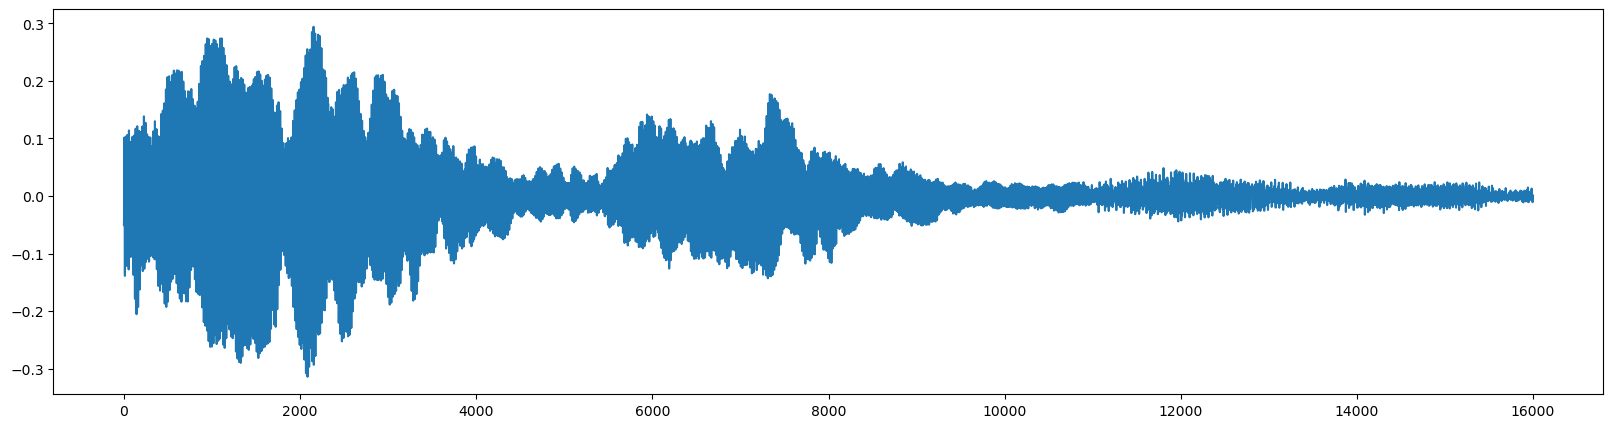

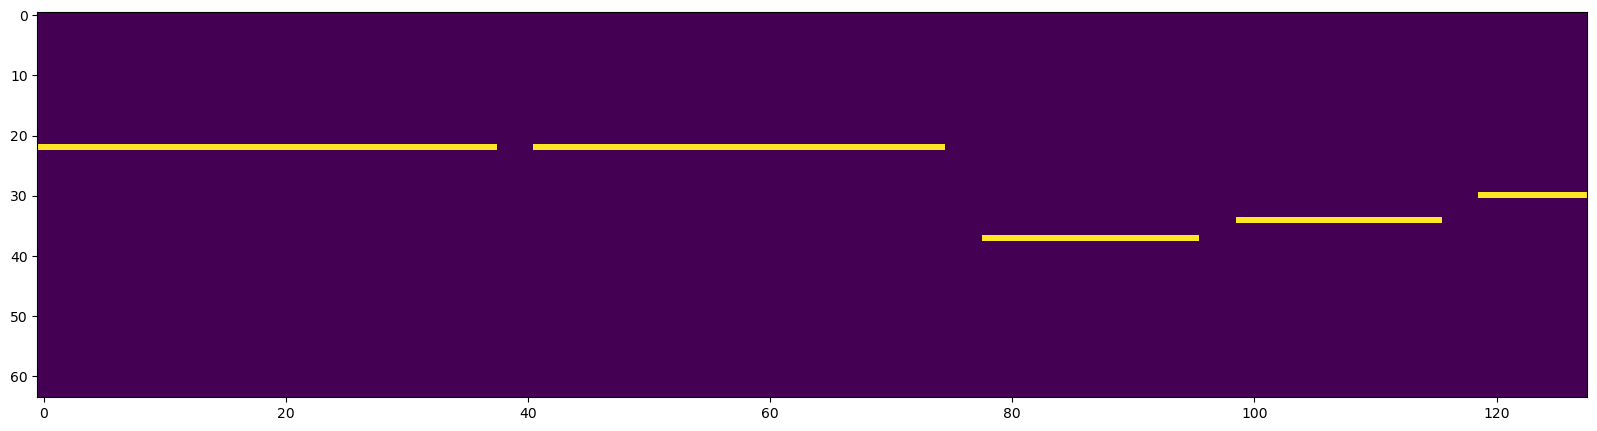

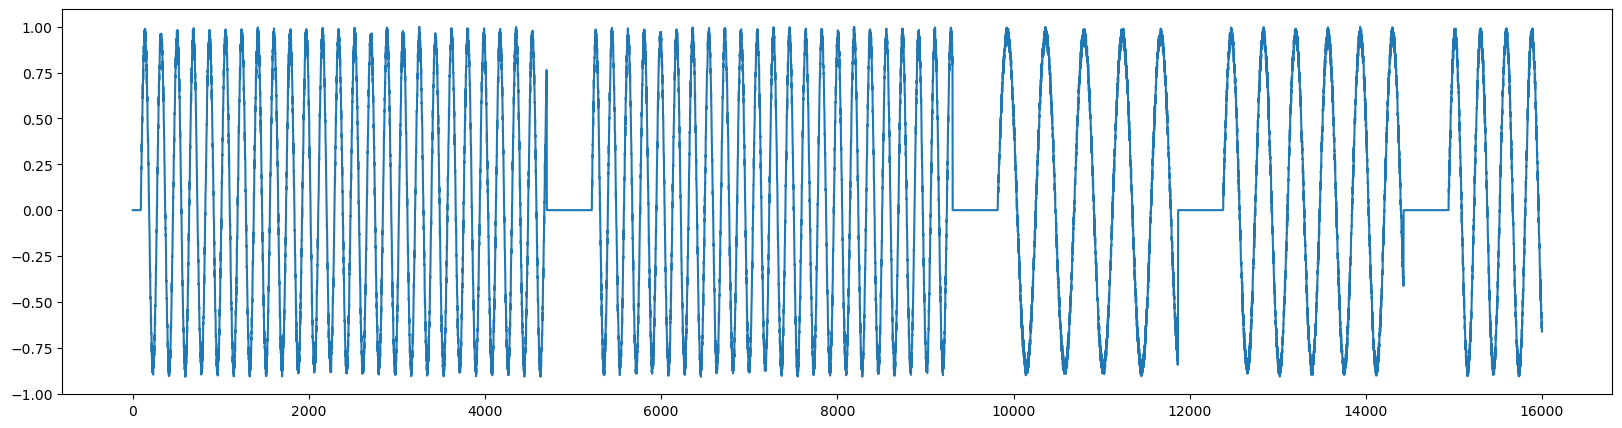

In [2]:
# compare a waveform and a piano roll

# load the waveform
waveform, sample_rate = torchaudio.load(new_audio_path)

# load the piano roll
piano_roll = np.load(new_proll_path)

# load the synthesized waveform
syn_waveform, sample_rate = torchaudio.load(new_syn_path)

audio = waveform
syn = syn_waveform
proll = piano_roll

SAMPLE_RATE = FREQ

audio_len = waveform.shape[1]
start = np.random.randint(0, audio_len - SAMPLE_RATE)
audio = audio[:,start:start+SAMPLE_RATE]
syn = syn[:,start:start+SAMPLE_RATE]
proll_start = int(start*MEL_FREQ//FREQ)
proll = proll[:,proll_start:proll_start+MEL_FREQ]

waveform = audio
syn_waveform = syn
piano_roll = proll

import matplotlib.pyplot as plt

# plot the waveform
plt.figure(figsize=(20, 5))
plt.plot(waveform[0].numpy())

# plot the piano roll
plt.figure(figsize=(20, 5))
plt.imshow(piano_roll[::-1, :], aspect='auto')

# plot the synthesized waveform
plt.figure(figsize=(20, 5))
plt.plot(syn_waveform[0].numpy())

plt.show()





In [ ]:
# hear the synthesized waveform
import IPython.display as ipd
ipd.Audio(syn_waveform, rate=SAMPLE_RATE)